# Hyperparameter Optimization and Evaluation

This notebook shows how to use the *BruteForce* optimizer module together with a **Midi2Vec** *Pipeline* to evaluate a large number of *Encoder* and *SequenceLearner* hyperparameter combinations against a given training set.

* **Encoder**: trains a *Doc2Vec* model against textual representations of MIDI files and uses this model to convert MIDI files into sequences of real-valued vectors.
* **SequenceLearner**: uses a *Keras* LSTM to learn patterns in sequences of real-valued vectors and, once trained, can generate new sequences of such vectors.
* **Pipeline**: combines various **Midi2Vec** components for encoding, sequence learning and evaluation into a single interface.
* **BruteForce**: Computes and evaluates all possible hyperparameter combinations within user-specified ranges.

## Imports

In [1]:
import sys
import time
import logging
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
import itertools

# Add Midi2Vec framework to Python working directory
sys.path.append('../')

from data_loading import MidiDataLoader
from midi_to_dataframe import NoteMapper
from pipeline import GenerativePipeline
from optimization import BruteForce
from evaluation import F1Evaluator, LossEvaluator

Using TensorFlow backend.


## Logging Configuration

In [2]:
logger = logging.getLogger()
logger.level = logging.INFO
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

# Disable Gensim (Doc2Vec) output
logging.getLogger("gensim").setLevel(logging.WARNING)

## Brute-Force Hyperparameter Sweep Values

All individual hyperparameter values to evaluate should be explicitly defined below. The *BruteForce* module will then compute all possible permutations and train and evaluate the corresponding modules using each computed set of parameters.

In [3]:
# Documents used to train semantic encoder model
docs_full = "../../data/1_measure_full.txt"

param_sweep_values = {

    # Encoder (doc2vec) settings:
    'doc2vec_docs': [docs_full],
    'doc2vec_dm': [1],
    'doc2vec_dm_mean': [1],
    'doc2vec_epochs': [1,2,4,8],
    'doc2vec_hs': [0],
    'doc2vec_learning_rate_start': [0.025],
    'doc2vec_learning_rate_end': [0.2],
    'doc2vec_min_count': [10],
    'doc2vec_negative': [15],
    'doc2vec_vector_size': [16],
    'doc2vec_window': [4],

    # Sequence learning (Keras LSTM) settings:
    'nn_features': [[]],
    'nn_batch_size': [16,32],
    'nn_dense_activation_function': ["linear"],
    'nn_dropout': [0],
    'nn_epochs': [1,2,4,8],
    'nn_hidden_neurons': [8,16,32],
    'nn_layers': [4,8,16,32],
    'nn_lstm_activation_function': ["selu"],
    'nn_lstm_n_prev': [8,16,32],
    'nn_loss': ['mean_squared_error'],
    'nn_optimizer': ['rmsprop']
}

# 'Variables' are those hyperparameters with multiple values defined
variables = []
for key, value in param_sweep_values.items():
    if len(value) > 1:
        variables.append(key)

## Sets of Sequences

Sets of stylistically-similar MIDI sequences to be used as training and evaluation material.

In [4]:
system_shock = ["../resources/midi/system_shock/cyberspace_clip_16.mid",
                "../resources/midi/system_shock/end_remix_clip_16.mid",
                "../resources/midi/system_shock/energy_clip_16.mid",
                "../resources/midi/system_shock/security_bridge_clip_16.mid"]

breakbeats = ["../resources/midi/breakbeats/084 Breakthru.mid",
             "../resources/midi/breakbeats/086 Clouds.mid",
             "../resources/midi/breakbeats/089 Get Out.mid",
             "../resources/midi/breakbeats/089 Wrong.mid",
             "../resources/midi/breakbeats/090 Deceive.mid",
             "../resources/midi/breakbeats/090 New York.mid",
             "../resources/midi/breakbeats/090 Radio.mid",
             "../resources/midi/breakbeats/093 Pretender.mid",
             "../resources/midi/breakbeats/093 Right Won.mid",
             "../resources/midi/breakbeats/094 Run.mid"]

jungle = ["../resources/midi/jungle/160 Jungle 05.mid",
          "../resources/midi/jungle/160 Jungle 11.mid",
          "../resources/midi/jungle/170 Jungle 01.mid",
          "../resources/midi/jungle/170 Jungle 03.mid",
          "../resources/midi/jungle/170 Jungle 04.mid",
          "../resources/midi/jungle/170 Jungle 06.mid",
          "../resources/midi/jungle/170 Jungle 07.mid",
          "../resources/midi/jungle/170 Jungle 08.mid",
          "../resources/midi/jungle/170 Jungle 09.mid",
          "../resources/midi/jungle/170 Jungle 10.mid",
          "../resources/midi/jungle/170 Jungle 12.mid",
          "../resources/midi/jungle/170 Jungle 13.mid",
          "../resources/midi/jungle/170 Jungle 14.mid",
          "../resources/midi/jungle/170 Jungle 15.mid",
          "../resources/midi/jungle/170 Jungle 16.mid",
          "../resources/midi/jungle/180 Jungle 02.mid"]

bach_chorales = ["../resources/midi/bach_chorales/01-AchGottundHerr.mid",
                 "../resources/midi/bach_chorales/02-AchLiebenChristen.mid",
                 "../resources/midi/bach_chorales/03-ChristederdubistTagundLicht.mid",
                 "../resources/midi/bach_chorales/04-ChristeDuBeistand.mid",
                 "../resources/midi/bach_chorales/05-DieNacht.mid",
                 "../resources/midi/bach_chorales/06-DieSonne.mid",
                 "../resources/midi/bach_chorales/07-HerrGott.mid",
                 "../resources/midi/bach_chorales/08-FuerDeinenThron.mid",
                 "../resources/midi/bach_chorales/09-Jesus.mid",
                 "../resources/midi/bach_chorales/10-NunBitten.mid"]

post_metal = ["../resources/midi/post_metal/isis_carry-01.mid",
              "../resources/midi/post_metal/isis_carry-02.mid",
              "../resources/midi/post_metal/isis_carry-03.mid",
              "../resources/midi/post_metal/isis_from-sinking-01.mid",
              "../resources/midi/post_metal/isis_from-sinking-02.mid",
              "../resources/midi/post_metal/isis_in-fiction-02.mid",
              "../resources/midi/post_metal/isis_in-fiction-03.mid",
              "../resources/midi/post_metal/isis_in-fiction-05.mid",
              "../resources/midi/post_metal/isis_pliable-foe-01.mid",
              "../resources/midi/post_metal/isis_the-beginning-and-the-end-01.mid",
              "../resources/midi/post_metal/isis_the-beginning-and-the-end-02.mid",
              "../resources/midi/post_metal/neurosis_locust-star-01.mid",
              "../resources/midi/post_metal/neurosis_no-river-to-take-me-home-01.mid",
              "../resources/midi/post_metal/russian-circles_harper-lewis-02.mid",
              "../resources/midi/post_metal/russian-circles_harper-lewis-03.mid"]

isis = ["../resources/midi/post_metal/isis/isis_carry-01.mid",
        "../resources/midi/post_metal/isis/isis_carry-02.mid",
        "../resources/midi/post_metal/isis/isis_carry-03.mid",
        "../resources/midi/post_metal/isis/isis_from-sinking-01.mid",
        "../resources/midi/post_metal/isis/isis_from-sinking-02.mid",
        "../resources/midi/post_metal/isis/isis_in-fiction-03.mid",
        "../resources/midi/post_metal/isis/isis_in-fiction-05.mid",
        "../resources/midi/post_metal/isis/isis_pliable-foe-01.mid",
        "../resources/midi/post_metal/isis/isis_the-beginning-and-the-end-02.mid"]

## Define Training Documents and DataLoader 

The training documents are MIDI sequences that the **Midi2Vec** model should learn to imitate and reproduce.

In [5]:
# Define note mapper for MIDI file loading
note_mapping_config_path = "../settings/map-to-group.json"
note_mapper = NoteMapper(note_mapping_config_path)

# Data loader used to encode MIDI-format training files
data_loader = MidiDataLoader(note_mapper)

# Define training documents for sequence learning
training_docs = breakbeats

## Define Callback Function

This function is called after every iteration of *SequenceLearner* model training. It controls outputting intermediary results and can trigger early stopping of the evaluation pipeline. Since the space of all hyperparameter combinations to evaluate can be exponentially large, it can make sense to implement reasonable early stopping criteria, i.e. after a given number of single evaluations or a predetermined amount of time.

In [6]:
results_dfs = []
runs_completed = [0]
start_time = time.time()
hours = 1
max_runtime = hours*60*60

def callback(params, score, abort):
    runs_completed[0] += 1
    merged = {**params, **score}
    merged['nn_features'] = ', '.join(merged['nn_features'])
    print("Completed " + str(runs_completed[0]) + " runs.")
    print(merged)
    results_dfs.append(pd.DataFrame(merged, index=[0]))
    elapsed_time = time.time() - start_time
    print(str(elapsed_time) + " seconds elapsed so far.")
    if elapsed_time >= max_runtime:
        print("Max. runtime reached.")
        abort()

## Build and Run the Pipeline

In [ ]:
pipeline = GenerativePipeline()
pipeline.set_data_loader(data_loader)
pipeline.set_encoder_cache_dir("encoders")
pipeline.set_training_docs(training_docs)
pipeline.set_k_fold_cross_eval(k=3)
pipeline.set_evaluator(F1Evaluator())
pipeline.save_best_model("models", "breakbeats")

brute_force_param_sweep = BruteForce(params=param_sweep_values)
brute_force_param_sweep.set_callback(callback)
pipeline.set_optimizer(brute_force_param_sweep)

pipeline.run()

## Collect and Aggregate Results of Runs 

In [8]:
results_df = pd.concat(results_dfs)

# Alternatively: load previous results to inspect
#results_df = pd.read_csv('results/breakbeats_2018_06_03.csv')
#variables = []
#for column in results_df:
#    if len(results_df[column].unique()) > 1:
#        if column.startswith("nn_") or column.startswith("doc2vec_"):
#            variables.append(column)

## Graph Single Variables

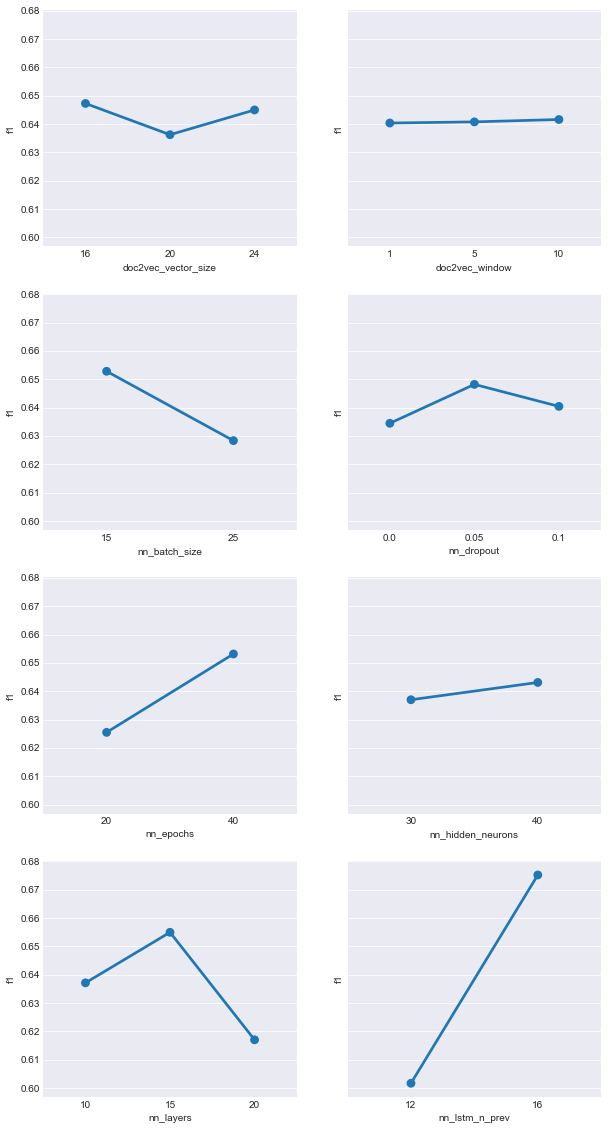

In [31]:
sns.set_style("darkgrid")

score = "f1"

# Get number of plots to create
num_plots = len(variables)       
dim = math.ceil(num_plots / 2)

# Set up figures for plots
fig, axes = plt.subplots(dim, 2, sharex=False, sharey=True)
fig.set_size_inches(10, dim*5) # width, height

for axis_index, variable in enumerate(variables):
    grouped = results_df[[variable, score]].groupby([variable], as_index=False).median()
    sns.pointplot(x=variable, y=score, data=grouped, ax=axes.flat[axis_index])

## Graph Variable Interactions

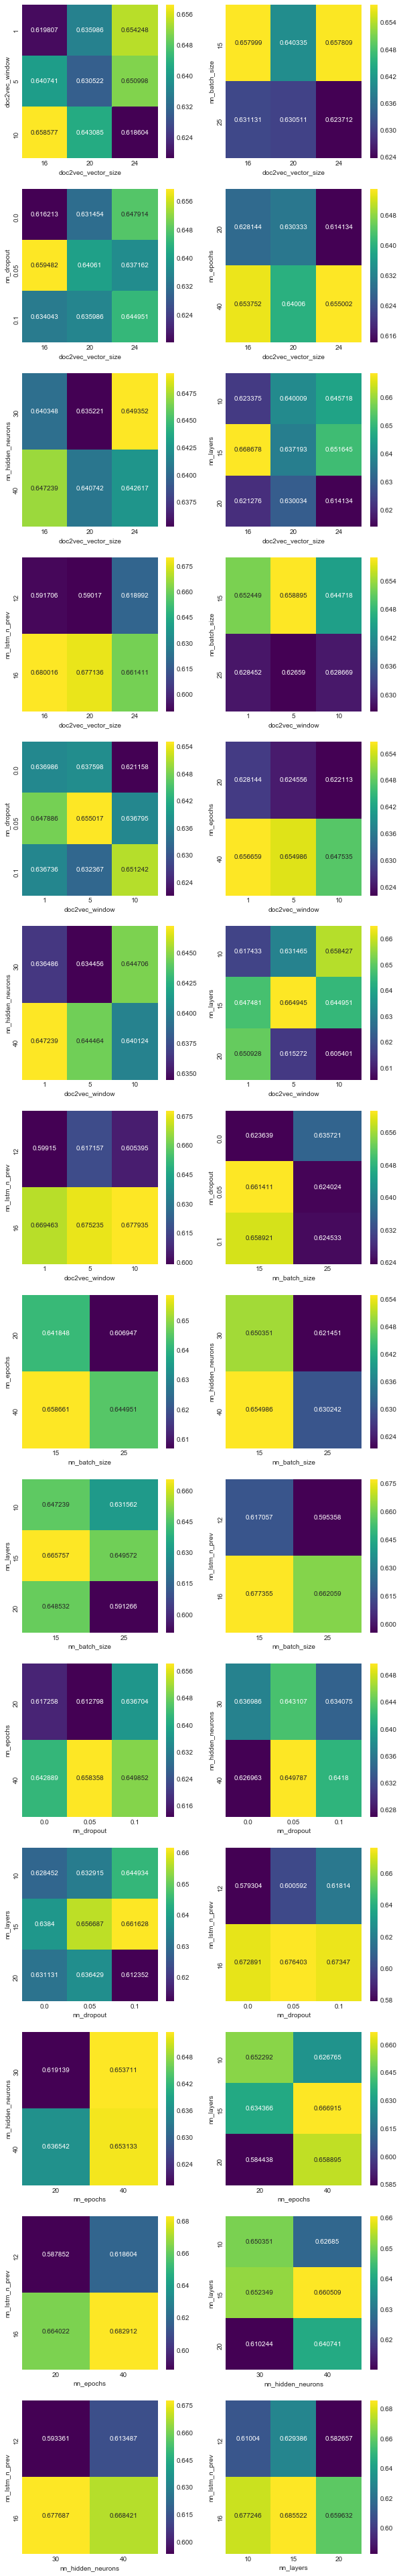

In [32]:
combinations = list(itertools.combinations(variables, r=2))
plots_per_row = 2
inches_per_plot = 5

# Number of plots to render
num_plots = len(combinations)            
dim = math.ceil(num_plots / plots_per_row)

# Set up figures for plots
fig, axes = plt.subplots(dim, plots_per_row, sharex=False, sharey=False)
fig.set_size_inches(plots_per_row * inches_per_plot, dim * inches_per_plot) # width, height

# Plot each pair of variables against each other on a heatmap
for axis_index, (heatmap_x, heatmap_y) in enumerate(combinations):
    grouped = results_df.groupby([heatmap_y, heatmap_x], as_index=False).median()
    pivoted = grouped.pivot(heatmap_y, heatmap_x, score)
    sns.heatmap(pivoted, annot=True, fmt="g", cmap='viridis', ax=axes.flat[axis_index])
    axis_index += 1

## Store Results of Evaluation Run

In [ ]:
#results_df.to_csv("breakbeats_2018_06_03.csv")